In [1]:
import re
import os
import glob
import shutil
import requests
import random
import pandas as pd
import nltk
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.externals import joblib
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.model_selection import cross_validate,StratifiedKFold
rcParams['figure.figsize'] = 12, 8

/Users/jill/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# 1. Data set path

In [2]:
train_path="/Users/jill/Downloads/2019_fall_semester/personal_project/nltk_practice/2010_i2b2_data/training_data/"
test_path="/Users/jill/Downloads/2019_fall_semester/personal_project/nltk_practice/2010_i2b2_data/test_data/"
tag_path="/Users/jill/Downloads/2019_fall_semester/personal_project/nltk_practice/2010_i2b2_data/annotated_file/"

In [3]:
out_data_trainPath="/Users/jill/Downloads/2019_fall_semester/personal_project/nltk_practice/out_data/train/"
out_data_validPath="/Users/jill/Downloads/2019_fall_semester/personal_project/nltk_practice/out_data/valid/"
out_data_testPath="/Users/jill/Downloads/2019_fall_semester/personal_project/nltk_practice/out_data/test/"

# 2. Load training and test data

In [4]:
training = pd.read_csv(os.path.join(out_data_trainPath,"train.csv"),index_col=False)
test = pd.read_csv(os.path.join(out_data_testPath,"test.csv"), index_col = False)

# 3. Bag of WORDS, TF-IDF, Ngram TF-IDF & XGBoost

### *a. Feature extraction*

In [5]:
def extract_features(train_df, test_df, mode, vocabulary_size):
    """
    Use different mode to create train and test arrays for XGBoost model.
    Create vocabulary dictionary to extract important features in the following steps.
    Return arrays and vocabulary dictionary.
    """
    if mode == "BOW":
        bow_vector = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=vocabulary_size)
        bow_vector.fit(train_df['clean_text'].unique())
        features_train = bow_vector.transform(train_df['clean_text'].values).toarray()
        features_test = bow_vector.transform(test_df['clean_text'].values).toarray()
        vocab_dic = bow_vector.vocabulary_
    
    elif mode == "TFIDF":
        tfidf_vector = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=vocabulary_size)
        tfidf_vector.fit(train_df['clean_text'].unique())
        features_train = tfidf_vector.transform(train_df['clean_text'].values).toarray()
        features_test = tfidf_vector.transform(test_df['clean_text'].values).toarray()
        vocab_dic = tfidf_vector.vocabulary_
        
    elif mode == "Ngram_TFIDF":
        ngramTfidf_vector = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}',
                                             ngram_range=(2,5), max_features=vocabulary_size)
        ngramTfidf_vector.fit(train_df['clean_text'].unique())
        features_train = ngramTfidf_vector.transform(train_df['clean_text'].values).toarray()
        features_test = ngramTfidf_vector.transform(test_df['clean_text'].values).toarray()
        vocab_dic = ngramTfidf_vector.vocabulary_
        
    y_train = train_df['CAD'].values
    y_test = test_df['CAD'].values
    return features_train, y_train, features_test, y_test, vocab_dic

### *b. Modeling, prediction and important features*

In [6]:
def important_feature(estimator, vocab_dic):
    
    feat_imp = pd.Series(estimator.get_booster().get_score(importance_type='weight')).sort_values(ascending=False).iloc[:30] 
    feat_imp.plot(kind='bar', title = "Important Features")
    plt.ylabel('Feature Importance Score')

In [7]:
def model_pred(X_train, y_train, X_test, y_test, vocab_dic):
    xgb_model = xgb.XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, 
                              colsample_bytree=.7, gamma=0, reg_alpha=4, objective='binary:logistic', 
                              eta=0.3, silent=1, subsample=0.8)
    xgb_model.fit(X_train, y_train)
    pred_prob_train = xgb_model.predict_proba(X_train)
    pred_prob_test = xgb_model.predict_proba(X_test)
    
    print ("\nModel Report: \n")
    print ("Auc Train Score: %.4g" % metrics.roc_auc_score(y_train,pred_prob_train[:,1]))
    print ("Auc Test Score: %f" % metrics.roc_auc_score(y_test,pred_prob_test[:,1]))
    
    print ("Detailed classification report: \n")
    y_true, y_pred = y_test,xgb_model.predict(X_test)
    print ((classification_report(y_true, y_pred)))
    important_feature(xgb_model, vocab_dic)

### *c. Cross validation*

In [8]:
def cv_modeling (X_train, y_train, X_test, y_test):
    
    xgb_model = xgb.XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, 
                              colsample_bytree=.7, gamma=0, reg_alpha=4, objective='binary:logistic', 
                              eta=0.3, silent=1, subsample=0.8)
    xgb_model.fit(X_train, y_train)
    kfold = StratifiedKFold(n_splits=10, random_state=42)
    cv_results = cross_validate(xgb_model, X_train, y_train, cv = kfold, scoring = 'roc_auc',return_train_score=True)
    results_df = pd.DataFrame(cv_results)
    return results_df

BOW XGBoost results: 


Model Report: 

Auc Train Score: 0.9994
Auc Test Score: 0.968180
Detailed classification report: 

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       192
           1       0.83      0.89      0.86        64

    accuracy                           0.93       256
   macro avg       0.89      0.91      0.90       256
weighted avg       0.93      0.93      0.93       256


Word level BOW XGBoost cv results: 

   fit_time  score_time  test_score  train_score
0  3.230972    0.003415    0.994652     0.999784
1  3.073998    0.003273    0.983957     0.999245
2  3.041014    0.003209    0.949198     0.999497
3  3.121131    0.003215    0.977961     0.999534
4  2.993982    0.003440    0.936364     0.999574
5  3.110835    0.003176    0.939394     0.999184
6  3.100877    0.003232    0.954545     0.999752
7  3.113711    0.003428    0.972727     0.999610
8  3.019749    0.003078    0.975758     0.999539
9  3.085350    0.00313

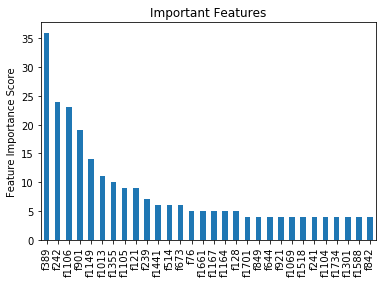

In [9]:
# BOW & XGBoost
X_train, y_train, X_test, y_test, vocab_dic = extract_features(training, test, "BOW", 2000)

print ("BOW XGBoost results: \n")
model_pred(X_train, y_train, X_test, y_test, vocab_dic)
bow_cv = cv_modeling (X_train, y_train, X_test, y_test)
print ("\nWord level BOW XGBoost cv results: \n")
print (bow_cv)

Word level TF-IDF XGBoost results: 


Model Report: 

Auc Train Score: 0.9999
Auc Test Score: 0.966349
Detailed classification report: 

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       192
           1       0.83      0.89      0.86        64

    accuracy                           0.93       256
   macro avg       0.89      0.91      0.90       256
weighted avg       0.93      0.93      0.93       256


Word level TF-IDF XGBoost cv results: 

   fit_time  score_time  test_score  train_score
0  2.914013    0.003624    0.983957     0.999928
1  2.959106    0.003178    0.983957     0.999784
2  2.903317    0.003361    0.927807     1.000000
3  3.008081    0.003308    0.972452     0.999928
4  3.072300    0.003299    0.948485     1.000000
5  3.279920    0.003872    0.942424     0.999894
6  3.426909    0.003634    0.948485     1.000000
7  3.233576    0.003399    0.990909     0.999965
8  2.908346    0.003214    0.975758     0.999929
9  2.

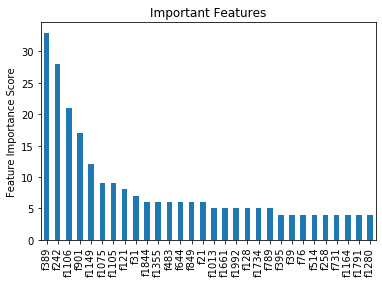

In [10]:
X_train, y_train, X_test, y_test, vocab_dic = extract_features(training, test, "TFIDF", 2000)

print ("Word level TF-IDF XGBoost results: \n")
model_pred(X_train, y_train, X_test, y_test, vocab_dic)

tfidf_cv = cv_modeling (X_train, y_train, X_test, y_test)
print ("\nWord level TF-IDF XGBoost cv results: \n")
print (tfidf_cv)

Ngram level TF-IDF XGBoost results: 


Model Report: 

Auc Train Score: 0.9983
Auc Test Score: 0.973307
Detailed classification report: 

              precision    recall  f1-score   support

           0       0.95      0.94      0.95       192
           1       0.83      0.84      0.84        64

    accuracy                           0.92       256
   macro avg       0.89      0.89      0.89       256
weighted avg       0.92      0.92      0.92       256


Ngram level TF-IDF XGBoost cv results: 

   fit_time  score_time  test_score  train_score
0  3.228444    0.003490    0.986631     0.998040
1  3.146484    0.003250    0.930481     0.998418
2  3.094845    0.003495    0.868984     0.998220
3  3.264263    0.003302    0.966942     0.998333
4  3.113185    0.003384    0.912121     0.998245
5  3.211669    0.003222    0.943939     0.998883
6  3.123946    0.003374    0.893939     0.998883
7  3.251308    0.003551    0.984848     0.997996
8  3.157065    0.003334    0.939394     0.998245
9  

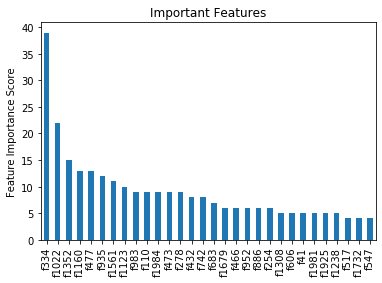

In [11]:
X_train, y_train, X_test, y_test, vocab_dic = extract_features(training, test, "Ngram_TFIDF", 2000)

print ("Ngram level TF-IDF XGBoost results: \n")
model_pred(X_train, y_train, X_test, y_test, vocab_dic)
ngram_cv = cv_modeling (X_train, y_train, X_test, y_test)
print ("\nNgram level TF-IDF XGBoost cv results: \n")
print (ngram_cv)